In [1]:
!pwd

/home/chen/dev/Digital-Twin-Fault-Diagnosis/scripts


In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import scipy.io
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

categories = [
    'Healthy',
    'Motor_1_Stuck',
    'Motor_1_Steady_state_error',
    'Motor_2_Stuck',
    'Motor_2_Steady_state_error',
    'Motor_3_Stuck',
    'Motor_3_Steady_state_error',
    'Motor_4_Stuck',
    'Motor_4_Steady_state_error'
]

# 定义一个函数来标准化特征
def normalize_features(X):
    mean = X.mean(dim=(0, 1), keepdim=True)  # 计算每个特征的均值
    std = X.std(dim=(0, 1), keepdim=True)  # 计算每个特征的标准差
    std[std == 0] = 1e-8  # 防止除以零
    X_normalized = (X - mean) / std  # 标准化
    return X_normalized

# 定义一个函数来计算模型的准确度
def print_confusion_matrix(y_test, predicted, categories):
    precision = precision_score(y_test.cpu(), predicted.cpu(), average='weighted')
    recall = recall_score(y_test.cpu(), predicted.cpu(), average='weighted')
    f1 = f1_score(y_test.cpu(), predicted.cpu(), average='weighted')
    print(f'Overall Test Accuracy: {accuracy * 100:.2f}%')
    # 绘制混淆矩阵
    cm = confusion_matrix(y_test.cpu(), predicted.cpu())
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
  # 打印每个类别的精确度、召回率和 F1 分数
    for i, category in enumerate(categories):
        precision = precision_score(y_test.cpu(), predicted.cpu(), labels=[i], average='weighted')
        recall = recall_score(y_test.cpu(), predicted.cpu(), labels=[i], average='weighted')
        f1 = f1_score(y_test.cpu(), predicted.cpu(), labels=[i], average='weighted')
        
        print(f'Category: {category},Precision: {precision:.2f},Recall: {recall:.2f},F1 Score: {f1:.2f}')
      

# 定义一个函数来将 .mat 文件转换为 PyTorch 张量
def transfer_tensor(mat, X_name, Y_name, mean=None, std=None):
     # 提取嵌套数组
    data_X = mat[X_name][0]  # 提取出嵌套的 object 数组
    data_Y = mat[Y_name][0]
    # 提取X到Tensor
    data_X_combined = np.array([data_X[i] for i in range(len(data_X))])
    # print(data_X_combined[0])
    data_tensor_X = torch.tensor(data_X_combined, dtype=torch.float32).to(device)  # 移到 GPU
    # 创建一个新的张量来存储处理后的数据
    data_tensor_X_with_residual = data_tensor_X.clone()  # 克隆一份以保留原始数据
    # 计算残差并替换后3个特征
    residual = data_tensor_X[:, :, :3] - data_tensor_X[:, :, 3:6]  # 计算残差
    data_tensor_X_with_residual[:, :, 3:6] = residual  # 将残差替换到后3个特征
    data_tensor_X = data_tensor_X_with_residual
    # 特征归一化
    if mean is None or std is None:
        # 如果未提供均值和标准差，则计算
        mean = data_tensor_X.mean(dim=(0, 1), keepdim=True)
        std = data_tensor_X.std(dim=(0, 1), keepdim=True)
    data_tensor_X = (data_tensor_X - mean) / std  # 标准化
    # 提取Y到Tensor
    data_Y_combined = np.array([data_Y[i] for i in range(len(data_Y))])
    data_Y_combined = data_Y_combined.flatten()
    # 创建字典，将每个类别映射到对应的序号
    category_to_index = {category: index for index, category in enumerate(categories)}
    data_Y_numeric = np.array([category_to_index[category] for category in data_Y_combined])
    # 将 NumPy 数组转换为 PyTorch 张量
    data_tensor_Y = torch.tensor(data_Y_numeric, dtype=torch.int64).to(device)  # 移到 GPU
    return data_tensor_X, data_tensor_Y, mean, std  # 返回均值和标准差


# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# load from .mat file as dictionary
mat = scipy.io.loadmat('../mydataset/my_dataset_train.mat')
mat_test = scipy.io.loadmat('../mydataset/my_dataset_test.mat')
# transfer data to tensor
data_tensor_X, data_tensor_Y, simulation_mean, simulation_std = transfer_tensor(mat, 'X_array', 'y_array')
data_tensor_X_real, data_tensor_Y_real, temp_mean, temp_std = transfer_tensor(mat_test, 'X_test_array', 'y_test_array', mean=simulation_mean, std=simulation_std)

print("tensor X:", data_tensor_X.shape)
print("tensor Y:", data_tensor_Y.shape)
print("tensor X real:", data_tensor_X_real.shape)
print("tensor Y real:", data_tensor_Y_real.shape)


Using device: cuda
tensor X: torch.Size([3600, 1000, 6])
tensor Y: torch.Size([3600])
tensor X real: torch.Size([90, 1000, 6])
tensor Y real: torch.Size([90])


In [3]:

# 训练和验证集的创建
training_ratio = 0.9
n_dataset = data_tensor_X.shape[0]
training_size = int(training_ratio * n_dataset)

# 随机打乱索引
indices = np.arange(n_dataset)
np.random.shuffle(indices)

# 划分训练集和测试集
train_indices = indices[:training_size]
test_indices = indices[training_size:]

X_train = data_tensor_X[train_indices]
X_test = data_tensor_X[test_indices]
y_train = data_tensor_Y[train_indices]
y_test = data_tensor_Y[test_indices]

#划分真实数据测试集
X_test_real = data_tensor_X_real
y_test_real = data_tensor_Y_real


# 从 models.py 中导入模型
from models import *

# 模型参数设置
input_size = 6  # 根据数据特征维度
num_classes = len(categories)
print(num_classes)
# 初始化模型并移到 GPU
# model = LSTMModel(input_size = input_size, hidden_size = 100, num_classes = num_classes).to(device)
# model = CNNModel(input_size = input_size, num_classes=num_classes).to(device)
model = ComplexCNN(input_size = input_size, num_classes=num_classes, num_channels=128).to(device)
# model = TransformerModel(input_size = input_size, hidden_size=32, num_classes=num_classes).to(device)
# model = TCN(input_size = input_size, output_size=num_classes, num_channels=[128,128,128]).to(device)
# model = MyTCN(input_size = input_size, num_classes=num_classes, num_channels=64).to(device)

# 存储 loss,acc 值的列表
losses_train = []
losses_test = []
losses_test_real = []
acc_train = []
acc_test = []
acc_test_real = []
temp_loss = 0
temp_acc = 0


9


Epoch [1/250], lr: 0.001, Train_Loss: 1.4958, Simu_val_Loss: 0.8486, Real_test_Loss: 1.3359, Train Accuracy: 40.90%, Simu_val_Accuracy: 74.44%, Real_test_Accuracy: 63.33%
Epoch [2/250], lr: 0.001, Train_Loss: 0.7504, Simu_val_Loss: 0.5435, Real_test_Loss: 1.8342, Train Accuracy: 72.24%, Simu_val_Accuracy: 81.67%, Real_test_Accuracy: 65.56%
Epoch [3/250], lr: 0.001, Train_Loss: 0.5125, Simu_val_Loss: 0.4736, Real_test_Loss: 2.2935, Train Accuracy: 82.48%, Simu_val_Accuracy: 83.33%, Real_test_Accuracy: 67.78%
Epoch [4/250], lr: 0.001, Train_Loss: 0.4298, Simu_val_Loss: 0.4695, Real_test_Loss: 2.5329, Train Accuracy: 84.80%, Simu_val_Accuracy: 81.67%, Real_test_Accuracy: 71.11%
Epoch [5/250], lr: 0.001, Train_Loss: 0.3926, Simu_val_Loss: 0.4513, Real_test_Loss: 2.7723, Train Accuracy: 85.75%, Simu_val_Accuracy: 83.33%, Real_test_Accuracy: 67.78%
Epoch [6/250], lr: 0.001, Train_Loss: 0.3604, Simu_val_Loss: 0.4292, Real_test_Loss: 3.0056, Train Accuracy: 86.83%, Simu_val_Accuracy: 83.89%, R

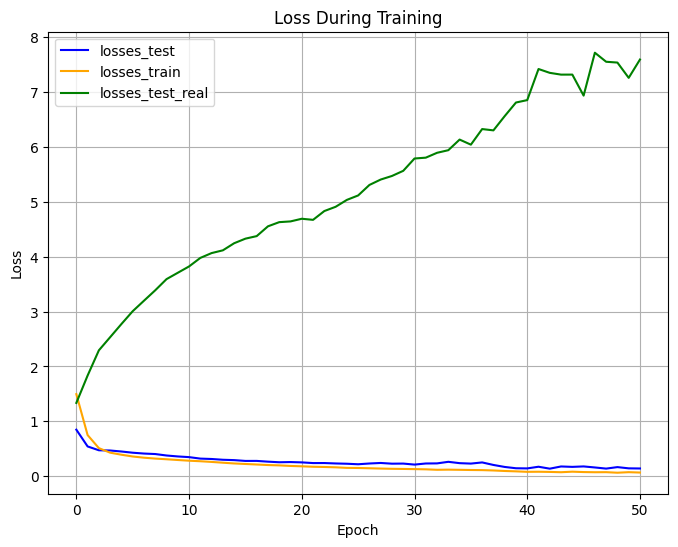

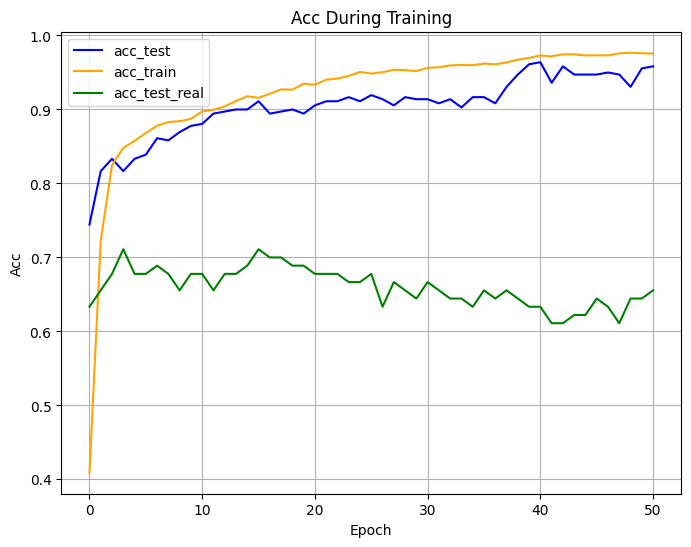

Epoch [51/250], lr: 0.001, Train_Loss: 0.0681, Simu_val_Loss: 0.1421, Real_test_Loss: 7.5880, Train Accuracy: 97.55%, Simu_val_Accuracy: 95.83%, Real_test_Accuracy: 65.56%
Epoch [52/250], lr: 0.001, Train_Loss: 0.0536, Simu_val_Loss: 0.1312, Real_test_Loss: 7.4937, Train Accuracy: 98.22%, Simu_val_Accuracy: 96.11%, Real_test_Accuracy: 65.56%
Epoch [53/250], lr: 0.001, Train_Loss: 0.0578, Simu_val_Loss: 0.1265, Real_test_Loss: 7.7087, Train Accuracy: 98.13%, Simu_val_Accuracy: 96.67%, Real_test_Accuracy: 67.78%
Epoch [54/250], lr: 0.001, Train_Loss: 0.0503, Simu_val_Loss: 0.1373, Real_test_Loss: 7.6171, Train Accuracy: 98.19%, Simu_val_Accuracy: 95.56%, Real_test_Accuracy: 63.33%
Epoch [55/250], lr: 0.001, Train_Loss: 0.0618, Simu_val_Loss: 0.1546, Real_test_Loss: 7.7167, Train Accuracy: 97.70%, Simu_val_Accuracy: 95.56%, Real_test_Accuracy: 66.67%
Epoch [56/250], lr: 0.001, Train_Loss: 0.0678, Simu_val_Loss: 0.1420, Real_test_Loss: 7.5356, Train Accuracy: 97.73%, Simu_val_Accuracy: 95.

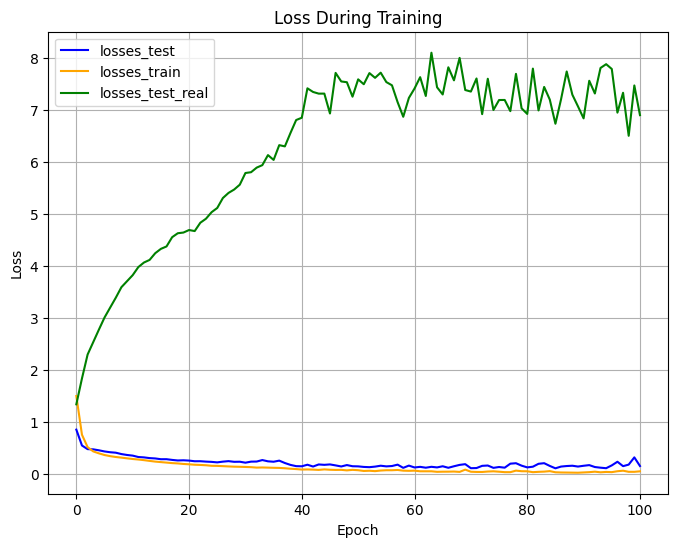

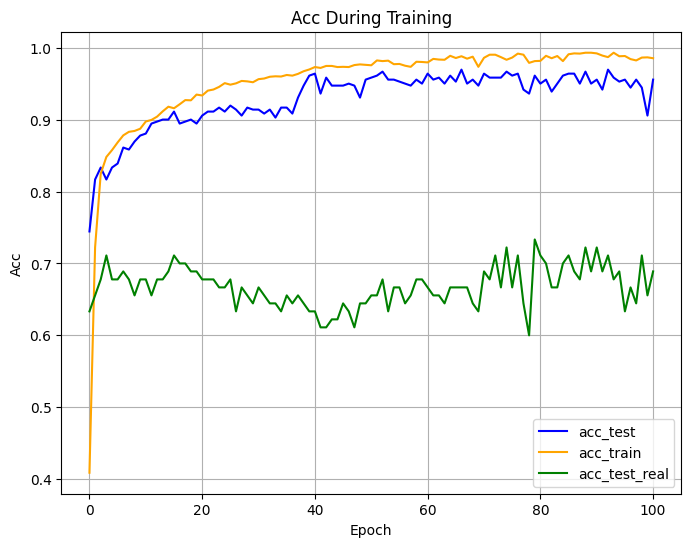

Epoch [101/250], lr: 0.001, Train_Loss: 0.0469, Simu_val_Loss: 0.1488, Real_test_Loss: 6.8993, Train Accuracy: 98.53%, Simu_val_Accuracy: 95.56%, Real_test_Accuracy: 68.89%
Epoch [102/250], lr: 0.001, Train_Loss: 0.0187, Simu_val_Loss: 0.1018, Real_test_Loss: 7.1893, Train Accuracy: 99.36%, Simu_val_Accuracy: 96.94%, Real_test_Accuracy: 72.22%
Epoch [103/250], lr: 0.001, Train_Loss: 0.0157, Simu_val_Loss: 0.1677, Real_test_Loss: 6.6142, Train Accuracy: 99.57%, Simu_val_Accuracy: 95.00%, Real_test_Accuracy: 68.89%
Epoch [104/250], lr: 0.001, Train_Loss: 0.0099, Simu_val_Loss: 0.1383, Real_test_Loss: 6.6314, Train Accuracy: 99.82%, Simu_val_Accuracy: 96.67%, Real_test_Accuracy: 70.00%
Epoch [105/250], lr: 0.001, Train_Loss: 0.0175, Simu_val_Loss: 0.1279, Real_test_Loss: 6.8898, Train Accuracy: 99.42%, Simu_val_Accuracy: 96.94%, Real_test_Accuracy: 70.00%
Epoch [106/250], lr: 0.001, Train_Loss: 0.0301, Simu_val_Loss: 0.1828, Real_test_Loss: 6.4001, Train Accuracy: 98.87%, Simu_val_Accurac

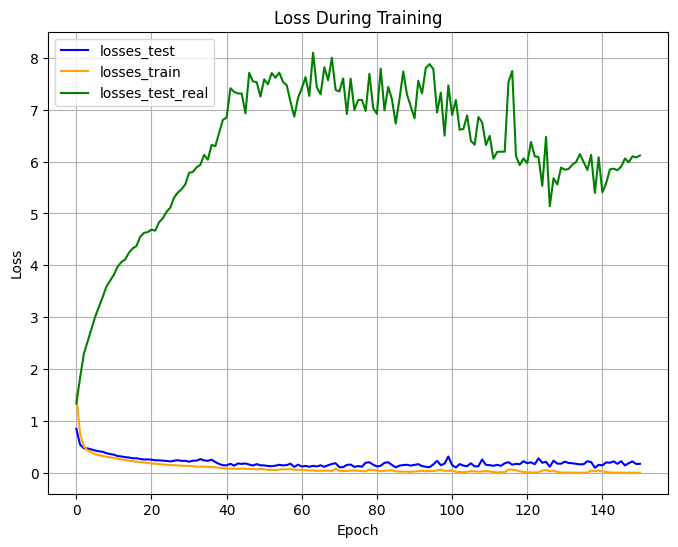

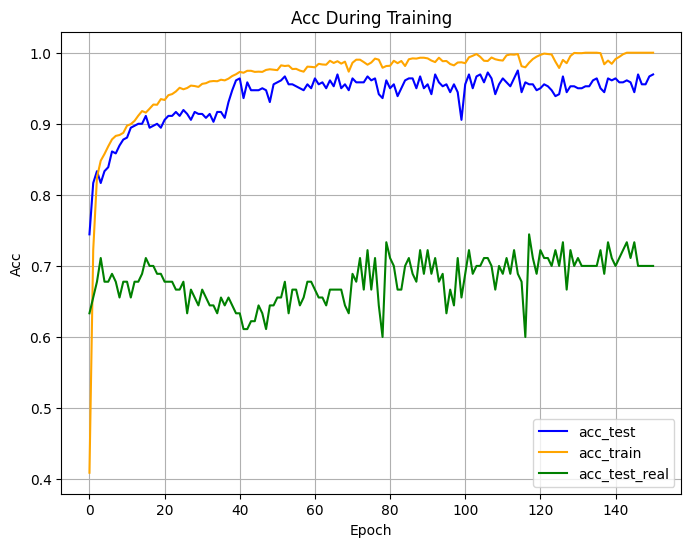

Epoch [151/250], lr: 0.001, Train_Loss: 0.0012, Simu_val_Loss: 0.1724, Real_test_Loss: 6.1174, Train Accuracy: 100.00%, Simu_val_Accuracy: 96.94%, Real_test_Accuracy: 70.00%
Epoch [152/250], lr: 0.001, Train_Loss: 0.0011, Simu_val_Loss: 0.1538, Real_test_Loss: 6.1552, Train Accuracy: 100.00%, Simu_val_Accuracy: 97.22%, Real_test_Accuracy: 70.00%
Epoch [153/250], lr: 0.001, Train_Loss: 0.0010, Simu_val_Loss: 0.1789, Real_test_Loss: 6.3239, Train Accuracy: 100.00%, Simu_val_Accuracy: 96.39%, Real_test_Accuracy: 70.00%
Epoch [154/250], lr: 0.001, Train_Loss: 0.0011, Simu_val_Loss: 0.1903, Real_test_Loss: 6.2914, Train Accuracy: 100.00%, Simu_val_Accuracy: 95.28%, Real_test_Accuracy: 68.89%
Epoch [155/250], lr: 0.001, Train_Loss: 0.0008, Simu_val_Loss: 0.1758, Real_test_Loss: 6.3375, Train Accuracy: 100.00%, Simu_val_Accuracy: 95.83%, Real_test_Accuracy: 70.00%
Epoch [156/250], lr: 0.001, Train_Loss: 0.0007, Simu_val_Loss: 0.1679, Real_test_Loss: 6.2851, Train Accuracy: 100.00%, Simu_val_A

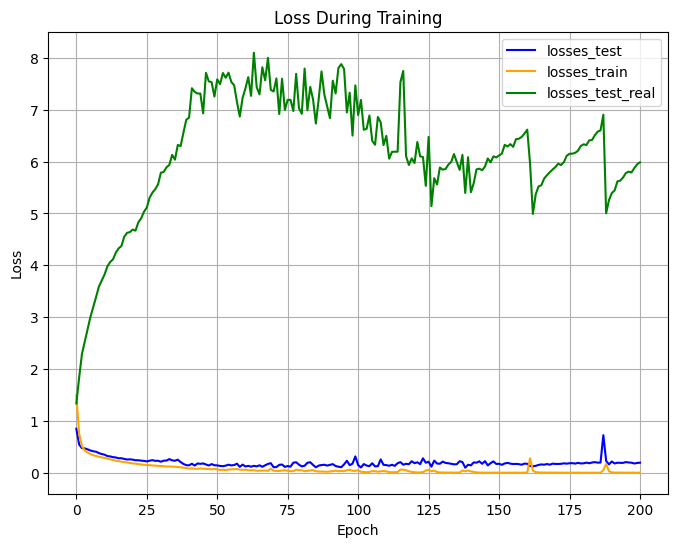

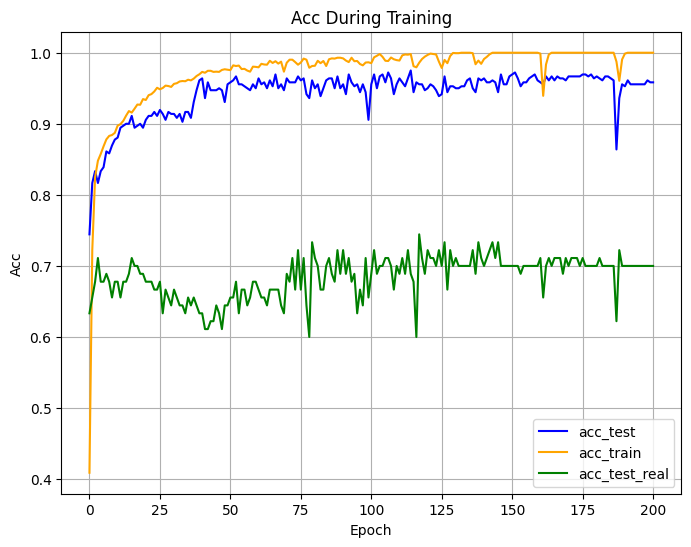

Epoch [201/250], lr: 0.001, Train_Loss: 0.0008, Simu_val_Loss: 0.1938, Real_test_Loss: 5.9869, Train Accuracy: 100.00%, Simu_val_Accuracy: 95.83%, Real_test_Accuracy: 70.00%
Epoch [202/250], lr: 0.001, Train_Loss: 0.0007, Simu_val_Loss: 0.1973, Real_test_Loss: 6.0007, Train Accuracy: 100.00%, Simu_val_Accuracy: 95.83%, Real_test_Accuracy: 70.00%
Epoch [203/250], lr: 0.001, Train_Loss: 0.0007, Simu_val_Loss: 0.1959, Real_test_Loss: 6.0341, Train Accuracy: 100.00%, Simu_val_Accuracy: 95.83%, Real_test_Accuracy: 70.00%
Epoch [204/250], lr: 0.001, Train_Loss: 0.0008, Simu_val_Loss: 0.2031, Real_test_Loss: 6.0833, Train Accuracy: 100.00%, Simu_val_Accuracy: 95.83%, Real_test_Accuracy: 70.00%
Epoch [205/250], lr: 0.001, Train_Loss: 0.0006, Simu_val_Loss: 0.1977, Real_test_Loss: 6.1632, Train Accuracy: 100.00%, Simu_val_Accuracy: 95.83%, Real_test_Accuracy: 70.00%
Epoch [206/250], lr: 0.001, Train_Loss: 0.0006, Simu_val_Loss: 0.1982, Real_test_Loss: 6.1393, Train Accuracy: 100.00%, Simu_val_A

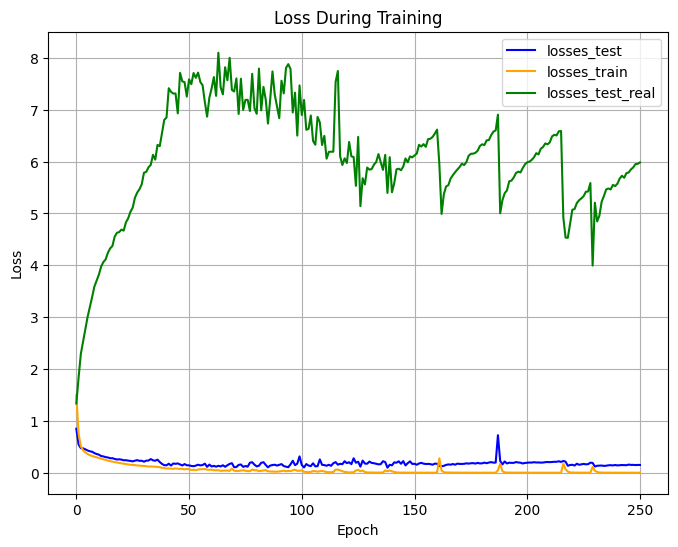

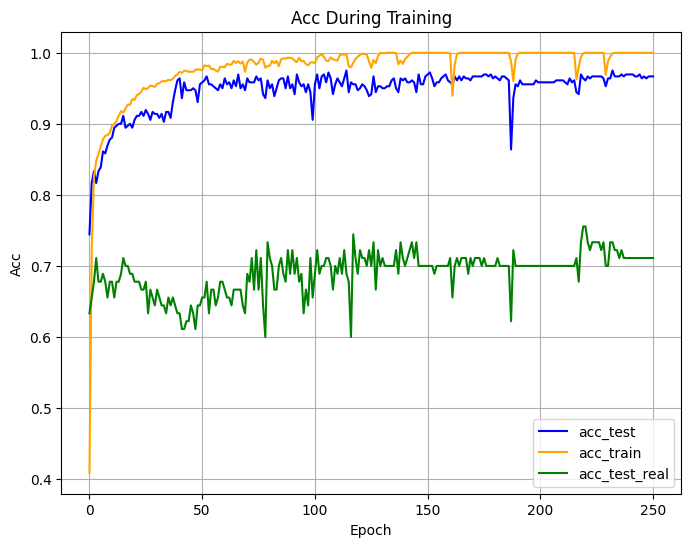

Epoch [251/250], lr: 0.001, Train_Loss: 0.0003, Simu_val_Loss: 0.1499, Real_test_Loss: 5.9847, Train Accuracy: 100.00%, Simu_val_Accuracy: 96.67%, Real_test_Accuracy: 71.11%
Overall Test Accuracy: 96.67%


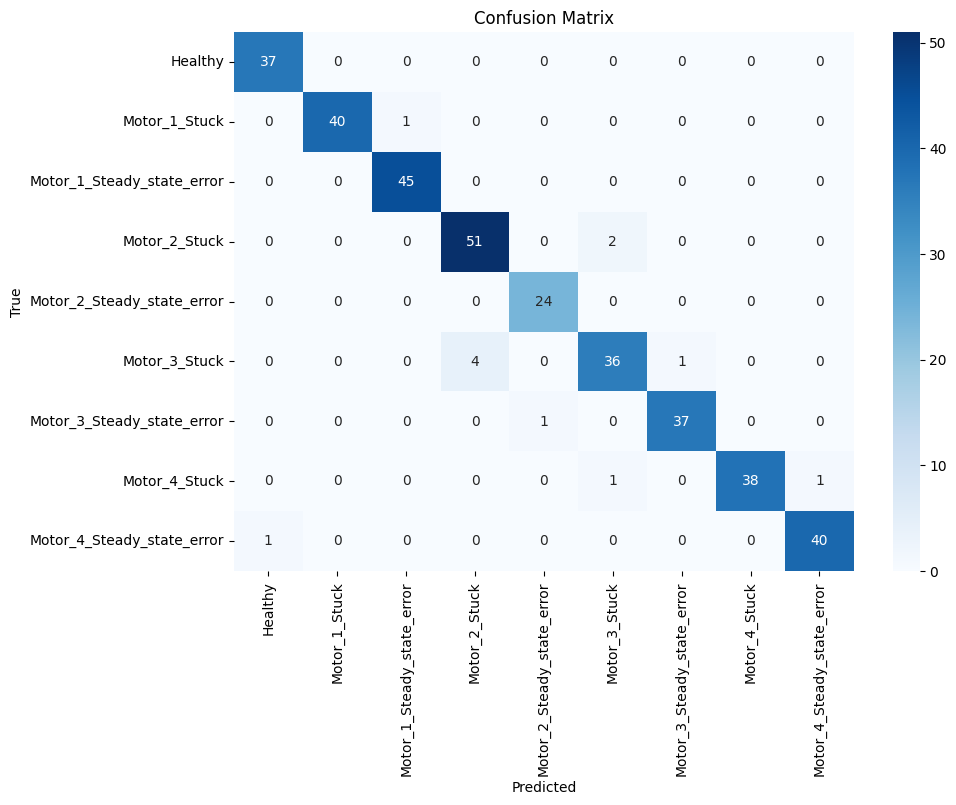

Category: Healthy,Precision: 0.97,Recall: 1.00,F1 Score: 0.99
Category: Motor_1_Stuck,Precision: 1.00,Recall: 0.98,F1 Score: 0.99
Category: Motor_1_Steady_state_error,Precision: 0.98,Recall: 1.00,F1 Score: 0.99
Category: Motor_2_Stuck,Precision: 0.93,Recall: 0.96,F1 Score: 0.94
Category: Motor_2_Steady_state_error,Precision: 0.96,Recall: 1.00,F1 Score: 0.98
Category: Motor_3_Stuck,Precision: 0.92,Recall: 0.88,F1 Score: 0.90
Category: Motor_3_Steady_state_error,Precision: 0.97,Recall: 0.97,F1 Score: 0.97
Category: Motor_4_Stuck,Precision: 1.00,Recall: 0.95,F1 Score: 0.97
Category: Motor_4_Steady_state_error,Precision: 0.98,Recall: 0.98,F1 Score: 0.98
Overall Test Accuracy: 96.67%


/home/chen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


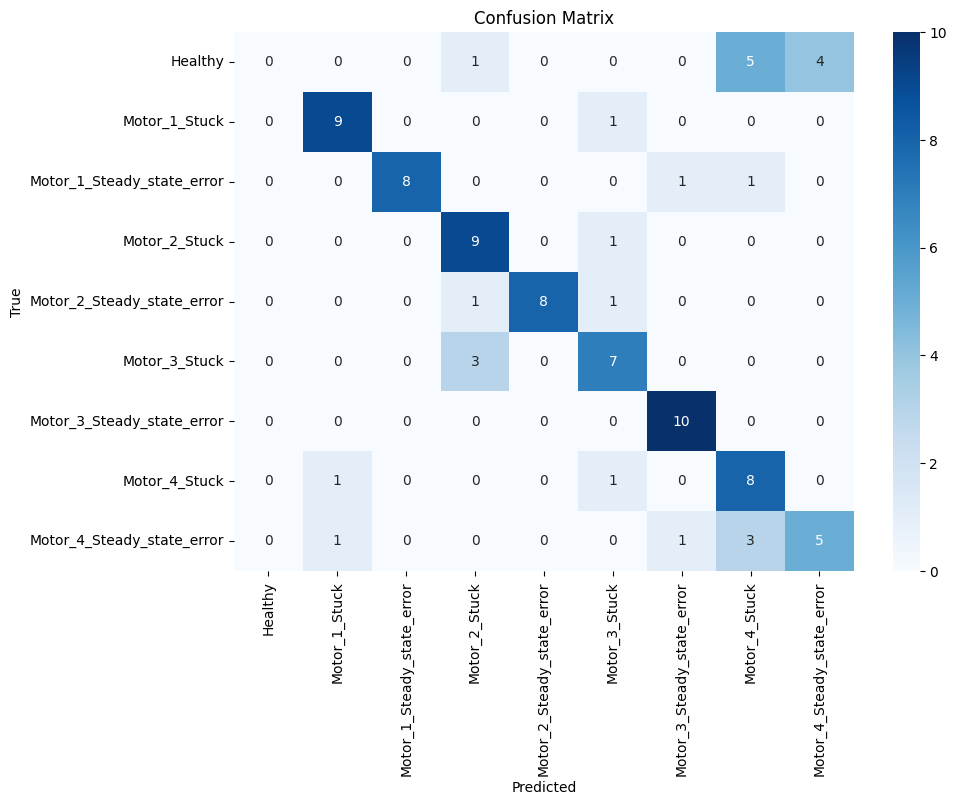

Category: Healthy,Precision: 0.00,Recall: 0.00,F1 Score: 0.00
Category: Motor_1_Stuck,Precision: 0.82,Recall: 0.90,F1 Score: 0.86
Category: Motor_1_Steady_state_error,Precision: 1.00,Recall: 0.80,F1 Score: 0.89
Category: Motor_2_Stuck,Precision: 0.64,Recall: 0.90,F1 Score: 0.75
Category: Motor_2_Steady_state_error,Precision: 1.00,Recall: 0.80,F1 Score: 0.89
Category: Motor_3_Stuck,Precision: 0.64,Recall: 0.70,F1 Score: 0.67
Category: Motor_3_Steady_state_error,Precision: 0.83,Recall: 1.00,F1 Score: 0.91
Category: Motor_4_Stuck,Precision: 0.47,Recall: 0.80,F1 Score: 0.59
Category: Motor_4_Steady_state_error,Precision: 0.56,Recall: 0.50,F1 Score: 0.53
Test Real Accuracy: 71.11%


/home/chen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
# 训练设置
# 不同的损失函数测试中，使用 CrossEntropyLoss/not use softmax 会导致测试集loss上升，使用softmax则正常
# criterion = nn.CrossEntropyLoss()

def criterion(logits, labels):
    # 使用 log_softmax 计算对数概率
    # logits = F.softmax(logits, dim=1)  #模拟在网络结构中最后一层添加一次softmax, 如果在logsoftmax前/后添加一次softmax，或者单独使用softmax就会正常，否则测试集loss就会上升
    log_probs = F.log_softmax(logits, dim=1)
    # log_probs = F.softmax(logits, dim=1)
    # log_probs = F.softmax(log_probs, dim=1)


    # 使用 NLLLoss 计算负对数似然损失
    loss_fn = nn.NLLLoss()
    loss = loss_fn(log_probs, labels)
    
    return loss

# def criterion(logits, labels):
#     labels = labels.to("cpu")
#     logits = logits.to("cpu")
#     # 使用 sigmoid 计算概率
#     probs = torch.sigmoid(logits)
    
#     # 使用 Binary Cross Entropy 计算损失
#     loss_fn = nn.BCELoss()  # 适用于多标签分类
#     one_hot_labels = torch.eye(num_classes)[labels]
#     loss = loss_fn(probs, one_hot_labels)
    
#     return loss

# parameters
mini_batch_size = 32
num_epochs = 250
learning_rate = 0.001
factor=0.1
patience=250
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)

# 训练模型
for epoch in range(num_epochs+1):

    temp_loss_all = []
    temp_acc_all = []
    model.train()  # 设置模型为训练模式
    for i in range(0, len(X_train), mini_batch_size):
        inputs = X_train[i:i + mini_batch_size].view(-1, 1000, input_size)  # 模型输入格式
        labels = y_train[i:i + mini_batch_size]

        # 前向传播
        outputs = model(inputs)

        _, predicted_train = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        with torch.no_grad():
            temp_loss_all.append(loss.item())
            temp_acc_all.append(accuracy_score(labels.cpu(), predicted_train.cpu()))

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 每轮打印测试准确率
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        temp_loss = np.mean(temp_loss_all)
        temp_acc = np.mean(temp_acc_all)

        test_outputs = model(X_test.view(-1, 1000, input_size))  # 模型输入格式
        _, predicted = torch.max(test_outputs.data, 1)
        loss = criterion(test_outputs, y_test)
        accuracy = accuracy_score(y_test.cpu(), predicted.cpu())

        test_outputs_real = model(X_test_real.view(-1, 1000, input_size))
        _, predicted_real = torch.max(test_outputs_real.data, 1)
        loss_real = criterion(test_outputs_real, y_test_real)
        accuracy_real = accuracy_score(y_test_real.cpu(), predicted_real.cpu())
        
        scheduler.step(loss.item())

        # 记录 loss acc
        losses_train.append(temp_loss)
        losses_test.append(loss.item())
        losses_test_real.append(loss_real.item())
        acc_train.append(temp_acc)
        acc_test.append(accuracy)
        acc_test_real.append(accuracy_real)


        # 打印和更新图表
        # clear_output(wait=True)
        if epoch%50==0 and epoch!=0:
            plt.figure(figsize=(8,6))
            plt.plot(losses_test, label="losses_test", color='blue')
            plt.plot(losses_train, label="losses_train", color='orange')
            plt.plot(losses_test_real, label="losses_test_real", color='green')
            plt.title('Loss During Training')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(8,6))
            plt.plot(acc_test, label="acc_test", color='blue')
            plt.plot(acc_train, label="acc_train", color='orange')
            plt.plot(acc_test_real, label="acc_test_real", color='green')
            plt.title('Acc During Training')
            plt.xlabel('Epoch')
            plt.ylabel('Acc')
            plt.legend()
            plt.grid(True)
            plt.show()

        current_lr = optimizer.param_groups[0]['lr']

        print(f'Epoch [{epoch + 1}/{num_epochs}], lr: {current_lr}, '
            f'Train_Loss: {temp_loss:.4f}, Simu_val_Loss: {loss.item():.4f}, Real_test_Loss: {loss_real.item():.4f}, '
            f'Train Accuracy: {temp_acc * 100:.2f}%, Simu_val_Accuracy: {accuracy * 100:.2f}%, Real_test_Accuracy: {accuracy_real * 100:.2f}%')



# confusion matrix for simulation validation and real test set
print_confusion_matrix(y_test, predicted, categories)
print_confusion_matrix(y_test_real, predicted_real, categories)

model.eval()  # 设置模型为评估模式
with torch.no_grad():
    test_outputs = model(X_test_real.view(-1, 1000, input_size))  # 模型输入格式
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test_real.cpu(), predicted.cpu())
    print(f'Test Real Accuracy: {accuracy * 100:.2f}%')
